In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
path ="./Excel_Inputs/TicketClassifierData.csv"

df_org= pd.read_csv(path)

df_org = df_org[df_org['Classification'].notnull()]

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Record_Notes,Classification
87,"7/18/2023 12:14:06 PM Kapeliela, Kelsey -0001 ...",Compressors/Motors
182,Bakery Freezer Door & Strip Curtain\rDamaged\r...,Non-Mechanical Door Repairs
878,"8/1/2023 6:14:01 PM Robak, Anthony -0001 \rAnt...",Compressors/Motors
747,WO/ COMPLETE Return to site needed 2nd tech to...,Compressors/Motors
283,"7/21/2023 4:28:59 PM Diaz, Ivan -0001 \rCall f...",Nuisance Calls


In [4]:
labels = df_org['Classification'].unique().tolist()
labels = [s.strip() for s in labels ]
labels


['Compressors/Motors',
 'Non-Mechanical Door Repairs',
 'Nuisance Calls',
 'Case Cleaning/Deicing',
 'Misc. Billable Repairs and Service Calls',
 'Capital Replacement',
 'Damage by Customer']

In [5]:
for key, value in enumerate(labels):
    print(value)

Compressors/Motors
Non-Mechanical Door Repairs
Nuisance Calls
Case Cleaning/Deicing
Misc. Billable Repairs and Service Calls
Capital Replacement
Damage by Customer


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
label2id

{'Compressors/Motors': 0,
 'Non-Mechanical Door Repairs': 1,
 'Nuisance Calls': 2,
 'Case Cleaning/Deicing': 3,
 'Misc. Billable Repairs and Service Calls': 4,
 'Capital Replacement': 5,
 'Damage by Customer': 6}

In [8]:
id2label

{0: 'Compressors/Motors',
 1: 'Non-Mechanical Door Repairs',
 2: 'Nuisance Calls',
 3: 'Case Cleaning/Deicing',
 4: 'Misc. Billable Repairs and Service Calls',
 5: 'Capital Replacement',
 6: 'Damage by Customer'}

In [9]:
df_org["labels"]=df_org.Classification.map(lambda x: label2id[x.strip()])

df_org.head()

,Record_Notes,Classification,labels
87,"7/18/2023 12:14:06 PM Kapeliela, Kelsey -0001 ...",Compressors/Motors,0
182,Bakery Freezer Door & Strip Curtain\rDamaged\r...,Non-Mechanical Door Repairs,1
878,"8/1/2023 6:14:01 PM Robak, Anthony -0001 \rAnt...",Compressors/Motors,0
747,WO/ COMPLETE Return to site needed 2nd tech to...,Compressors/Motors,0
283,"7/21/2023 4:28:59 PM Diaz, Ivan -0001 \rCall f...",Nuisance Calls,2


In [10]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)

model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
SIZE= df_org.shape[0]

train_texts= list(df_org.Record_Notes[:SIZE//2])

val_texts=   list(df_org.Record_Notes[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Record_Notes[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

len(train_texts), len(val_texts), len(test_texts)

(602, 301, 301)

In [12]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [13]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [14]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [15]:
from transformers import TrainingArguments, Trainer
import accelerate

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [17]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./BERTARGS', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=15,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.005,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)


In [19]:
trainer.train()

  9%|▉         | 50/570 [00:20<03:30,  2.47it/s]

{'loss': 1.7841, 'grad_norm': 5.27805757522583, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.32}


c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  9%|▉         | 50/570 [00:22<03:30,  2.47it/s]

{'eval_loss': 1.647851824760437, 'eval_Accuracy': 0.4950166112956811, 'eval_F1': 0.22854533117594864, 'eval_Precision': 0.2076220425277029, 'eval_Recall': 0.2789664252797893, 'eval_runtime': 2.1474, 'eval_samples_per_second': 140.171, 'eval_steps_per_second': 4.657, 'epoch': 1.32}


 18%|█▊        | 100/570 [00:43<03:10,  2.46it/s]

{'loss': 1.2162, 'grad_norm': 9.213211059570312, 'learning_rate': 4.8e-05, 'epoch': 2.63}


c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 18%|█▊        | 100/570 [00:45<03:10,  2.46it/s]

{'eval_loss': 0.8207772970199585, 'eval_Accuracy': 0.7275747508305648, 'eval_F1': 0.4713602875791785, 'eval_Precision': 0.5203289005278156, 'eval_Recall': 0.5072839619718855, 'eval_runtime': 2.1411, 'eval_samples_per_second': 140.585, 'eval_steps_per_second': 4.671, 'epoch': 2.63}


 26%|██▋       | 150/570 [01:05<02:50,  2.46it/s]

{'loss': 0.6386, 'grad_norm': 3.4033806324005127, 'learning_rate': 4.5106382978723406e-05, 'epoch': 3.95}


c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 26%|██▋       | 150/570 [01:07<02:50,  2.46it/s]

{'eval_loss': 0.7811802625656128, 'eval_Accuracy': 0.7873754152823921, 'eval_F1': 0.5584497324877687, 'eval_Precision': 0.5634778821455694, 'eval_Recall': 0.5710386305059658, 'eval_runtime': 2.16, 'eval_samples_per_second': 139.349, 'eval_steps_per_second': 4.63, 'epoch': 3.95}


 35%|███▌      | 200/570 [01:28<02:34,  2.40it/s]

{'loss': 0.4565, 'grad_norm': 4.09006929397583, 'learning_rate': 3.97872340425532e-05, 'epoch': 5.26}


c:\Users\Kevin\Desktop\Hackathon\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 35%|███▌      | 200/570 [01:30<02:34,  2.40it/s]

{'eval_loss': 0.6671614050865173, 'eval_Accuracy': 0.8172757475083057, 'eval_F1': 0.617680133191499, 'eval_Precision': 0.6235771279863948, 'eval_Recall': 0.6203725307327232, 'eval_runtime': 2.1659, 'eval_samples_per_second': 138.974, 'eval_steps_per_second': 4.617, 'epoch': 5.26}


 44%|████▍     | 250/570 [01:50<02:10,  2.45it/s]

{'loss': 0.2774, 'grad_norm': 7.656033992767334, 'learning_rate': 3.446808510638298e-05, 'epoch': 6.58}


                                                 
 44%|████▍     | 250/570 [01:52<02:10,  2.45it/s]

{'eval_loss': 0.7822851538658142, 'eval_Accuracy': 0.8039867109634552, 'eval_F1': 0.60297629007317, 'eval_Precision': 0.6076487029648953, 'eval_Recall': 0.6113304730494349, 'eval_runtime': 2.1804, 'eval_samples_per_second': 138.05, 'eval_steps_per_second': 4.586, 'epoch': 6.58}


 53%|█████▎    | 300/570 [02:13<01:49,  2.46it/s]

{'loss': 0.1924, 'grad_norm': 0.6173188090324402, 'learning_rate': 2.9148936170212765e-05, 'epoch': 7.89}


                                                 
 53%|█████▎    | 300/570 [02:15<01:49,  2.46it/s]

{'eval_loss': 0.7441727519035339, 'eval_Accuracy': 0.8073089700996677, 'eval_F1': 0.6328934130598531, 'eval_Precision': 0.7137371077463243, 'eval_Recall': 0.6341174104050223, 'eval_runtime': 2.1385, 'eval_samples_per_second': 140.75, 'eval_steps_per_second': 4.676, 'epoch': 7.89}


 61%|██████▏   | 350/570 [02:35<01:29,  2.46it/s]

{'loss': 0.1259, 'grad_norm': 5.872751235961914, 'learning_rate': 2.3829787234042557e-05, 'epoch': 9.21}


                                                 
 61%|██████▏   | 350/570 [02:38<01:29,  2.46it/s]

{'eval_loss': 0.8932701945304871, 'eval_Accuracy': 0.8106312292358804, 'eval_F1': 0.630941839370298, 'eval_Precision': 0.6919807721371225, 'eval_Recall': 0.6168160005937858, 'eval_runtime': 2.1741, 'eval_samples_per_second': 138.446, 'eval_steps_per_second': 4.6, 'epoch': 9.21}


 70%|███████   | 400/570 [02:58<01:09,  2.45it/s]

{'loss': 0.0771, 'grad_norm': 0.08010855317115784, 'learning_rate': 1.851063829787234e-05, 'epoch': 10.53}


                                                 
 70%|███████   | 400/570 [03:00<01:09,  2.45it/s]

{'eval_loss': 0.8022164702415466, 'eval_Accuracy': 0.8372093023255814, 'eval_F1': 0.663524113004532, 'eval_Precision': 0.6925850618127731, 'eval_Recall': 0.6617034448187878, 'eval_runtime': 2.1287, 'eval_samples_per_second': 141.399, 'eval_steps_per_second': 4.698, 'epoch': 10.53}


 79%|███████▉  | 450/570 [03:21<00:50,  2.38it/s]

{'loss': 0.0326, 'grad_norm': 0.07012136280536652, 'learning_rate': 1.3191489361702127e-05, 'epoch': 11.84}


                                                 
 79%|███████▉  | 450/570 [03:23<00:50,  2.38it/s]

{'eval_loss': 0.9071402549743652, 'eval_Accuracy': 0.8106312292358804, 'eval_F1': 0.6502414252414254, 'eval_Precision': 0.6548064084053891, 'eval_Recall': 0.6531240722095291, 'eval_runtime': 2.211, 'eval_samples_per_second': 136.135, 'eval_steps_per_second': 4.523, 'epoch': 11.84}


 88%|████████▊ | 500/570 [03:44<00:28,  2.45it/s]

{'loss': 0.0193, 'grad_norm': 2.697798252105713, 'learning_rate': 7.872340425531916e-06, 'epoch': 13.16}


                                                 
 88%|████████▊ | 500/570 [03:46<00:28,  2.45it/s]

{'eval_loss': 0.9057530760765076, 'eval_Accuracy': 0.8205980066445183, 'eval_F1': 0.6712616766891142, 'eval_Precision': 0.6896012480767278, 'eval_Recall': 0.6642285139862397, 'eval_runtime': 2.1393, 'eval_samples_per_second': 140.702, 'eval_steps_per_second': 4.674, 'epoch': 13.16}


 96%|█████████▋| 550/570 [04:09<00:08,  2.45it/s]

{'loss': 0.008, 'grad_norm': 0.10125429928302765, 'learning_rate': 2.553191489361702e-06, 'epoch': 14.47}


                                                 
 96%|█████████▋| 550/570 [04:11<00:08,  2.45it/s]

{'eval_loss': 0.9126272797584534, 'eval_Accuracy': 0.8172757475083057, 'eval_F1': 0.6677969554340535, 'eval_Precision': 0.682882740904664, 'eval_Recall': 0.6627404187481444, 'eval_runtime': 2.1557, 'eval_samples_per_second': 139.631, 'eval_steps_per_second': 4.639, 'epoch': 14.47}


100%|██████████| 570/570 [04:24<00:00,  2.15it/s]

{'train_runtime': 264.5463, 'train_samples_per_second': 34.134, 'train_steps_per_second': 2.155, 'train_loss': 0.4238317989466483, 'epoch': 15.0}


TrainOutput(global_step=570, training_loss=0.4238317989466483, metrics={'train_runtime': 264.5463, 'train_samples_per_second': 34.134, 'train_steps_per_second': 2.155, 'total_flos': 2375999490816000.0, 'train_loss': 0.4238317989466483, 'epoch': 15.0})

In [20]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.006645,1.000000,1.000000,1.000000,1.000000
val,0.905753,0.820598,0.671262,0.689601,0.664229
test,0.865510,0.850498,0.748564,0.767776,0.739986


In [21]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [22]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [23]:
import torch
torch.cuda.is_available()
cuda_id=torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce RTX 2060 SUPER'

In [24]:
# Test with a an example text 
text = "Please schedule a cleaning and maintenance service for refrigerated display cases MTB-02A and MTB-02B. Both units require thorough de-icing, coil cleaning, and drain unclogging to ensure optimal performance. The following actions are requested:De-icing: Both cases need to be de-iced, with special attention to the coils.Drain Cleaning: The drain on case MTB-02B was previously clogged. Please ensure the drain is cleared to prevent future blockages.Coil Maintenance: Clean the refrigeration coils in both cases to improve efficiency and prevent icing issues.Temperature Calibration: Verify that the set point of each case is properly maintained (set point is 28°F for both), and ensure temperature stability post-cleaning.Valve Operation Check: Confirm the proper functioning of refrigeration valves after cleaning and reassembly.Please coordinate with Manager Al Obregon for timing and product relocation during the cleaning process.Priority Level: MediumRequested Completion Date: [Insert Preferred Date]"


predict(text)

(tensor([[1.0457e-04, 1.5365e-04, 2.5481e-04, 9.9844e-01, 1.0478e-04, 4.0480e-04,
          5.3628e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(3, device='cuda:0'),
 'Case Cleaning/Deicing')

Save Model

In [25]:
model_path = "refrigerator-v1-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('refrigerator-v1-classification-model\\tokenizer_config.json',
 'refrigerator-v1-classification-model\\special_tokens_map.json',
 'refrigerator-v1-classification-model\\vocab.txt',
 'refrigerator-v1-classification-model\\added_tokens.json',
 'refrigerator-v1-classification-model\\tokenizer.json')

Reload Model

In [26]:
model_path = "refrigerator-v1-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [27]:
nlp(""""Got to the location and checked in with Manager POOJA SALOOJA when up to the pos cooler and found coil # 2 with an ice up drain pan. Got with Alan and he will fallow up on this call. He will be tomorrow to de-ice it. Talked to the manger to have those two plates move from the top to give him some room.

""")


[{'label': 'Case Cleaning/Deicing', 'score': 0.9984082579612732}]

In [28]:
# Function to tokenize the "Record Notes" with a max length of 512 tokens
'''
def tokenize_record_notes(note):
    # Tokenize and restrict to 512 tokens
    tokens = tokenizer(note, truncation=True, padding=True, max_length=512).to("cuda")
    return tokens['input_ids']
'''
# Function to run sentiment analysis on the tokenized input
def get_sentiment(note):
    # Run sentiment analysis using the pipeline, truncating to 512 tokens
    result = nlp(note, truncation=True,padding=True, max_length=512)  # Use truncation here
    return result[0]  # Return the label and score from the first result


In [29]:
df_evaluate = df_org
# Apply the tokenization to the "Record Notes" column
#df_first_three['tokenized_notes'] = df_first_three['Record_Notes'].apply(tokenize_record_notes)
# Apply the sentiment analysis to the original "Record Notes"
df_evaluate['sentiment'] = df_evaluate['Record_Notes'].apply(get_sentiment)
df_evaluate['Model_Classification'] = df_evaluate['sentiment'].apply(lambda x: x['label'])
df_evaluate['score'] = df_evaluate['sentiment'].apply(lambda x: x['score'])
# Drop the original sentiment column if you don't need it
df_evaluate = df_evaluate.drop(columns=['sentiment'])

# Display the updated DataFrame with separate sentiment label and score columns
print(df_evaluate[['Record_Notes','Classification', 'Model_Classification', 'score']])

                                           Record_Notes  \
87    7/18/2023 12:14:06 PM Kapeliela, Kelsey -0001 ...   
182   Bakery Freezer Door & Strip Curtain\rDamaged\r...   
878   8/1/2023 6:14:01 PM Robak, Anthony -0001 \rAnt...   
747   WO/ COMPLETE Return to site needed 2nd tech to...   
283   7/21/2023 4:28:59 PM Diaz, Ivan -0001 \rCall f...   
...                                                 ...   
1301  Cooper Nichols \r8/15/23\rArrival 1330\rDepart...   
1359  Arrived on site checked in went to motor room ...   
1404  -While on site inspected coils and verified al...   
1057       Replace 3 door gasket due to cuts on gaskets   
1400  8/17/2023 9:04:42 AM Becissa, Bachir -0001 \rC...   

                   Classification         Model_Classification     score  
87             Compressors/Motors           Compressors/Motors  0.997533  
182   Non-Mechanical Door Repairs  Non-Mechanical Door Repairs  0.996548  
878            Compressors/Motors           Compressors/Motors  0.

In [30]:
import openpyxl
# Define the output directory and filename
output_dir = "Excel_Outputs"
output_file = os.path.join(output_dir, "sentiment_analysis_results.xlsx")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Write the DataFrame to an Excel file
df_evaluate.to_excel(output_file, index=False)

print(f"DataFrame has been written to {output_file}")

DataFrame has been written to Excel_Outputs\sentiment_analysis_results.xlsx


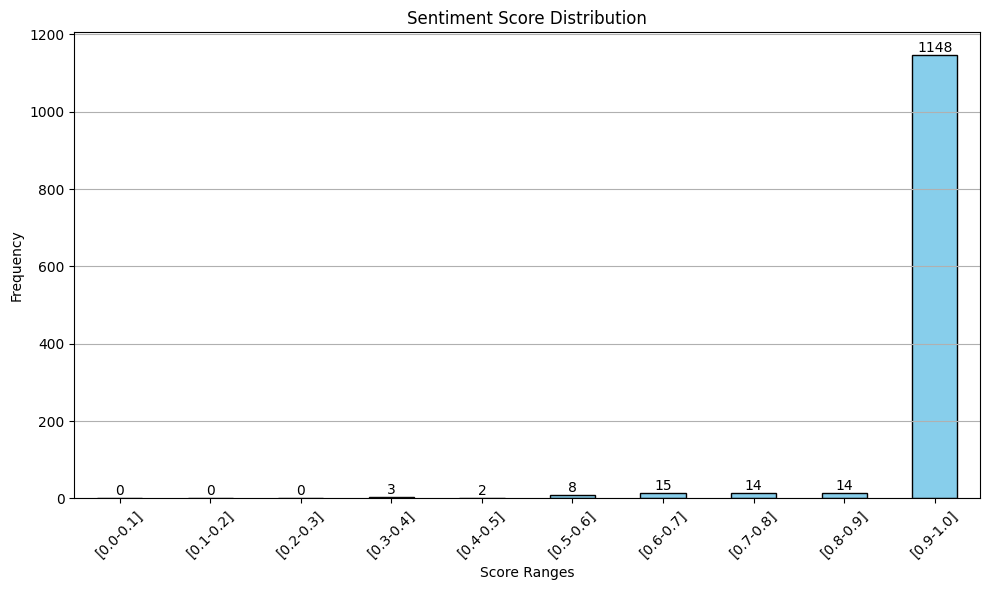

In [31]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel(output_file)

bins = [i/10 for i in range(11)]  # Bins: [0.0, 0.1, 0.2, ..., 1.0]
labels = [f'[{bins[i]}-{bins[i+1]}]' for i in range(len(bins)-1)]  # Labels for the bins

# Digitize the scores into the bins
df['score_bins'] = pd.cut(df['score'], bins=bins, labels=labels, include_lowest=True)

# Count occurrences in each bin
hist_data = df['score_bins'].value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
bars = hist_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Score Ranges')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add counts above the bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        bar.get_height(),  # Y position of the text
        int(bar.get_height()),  # The height of the bar (the count)
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

# Save the plot as an image file
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sentiment_score_histogram.png'))

# Show the plot
plt.show()

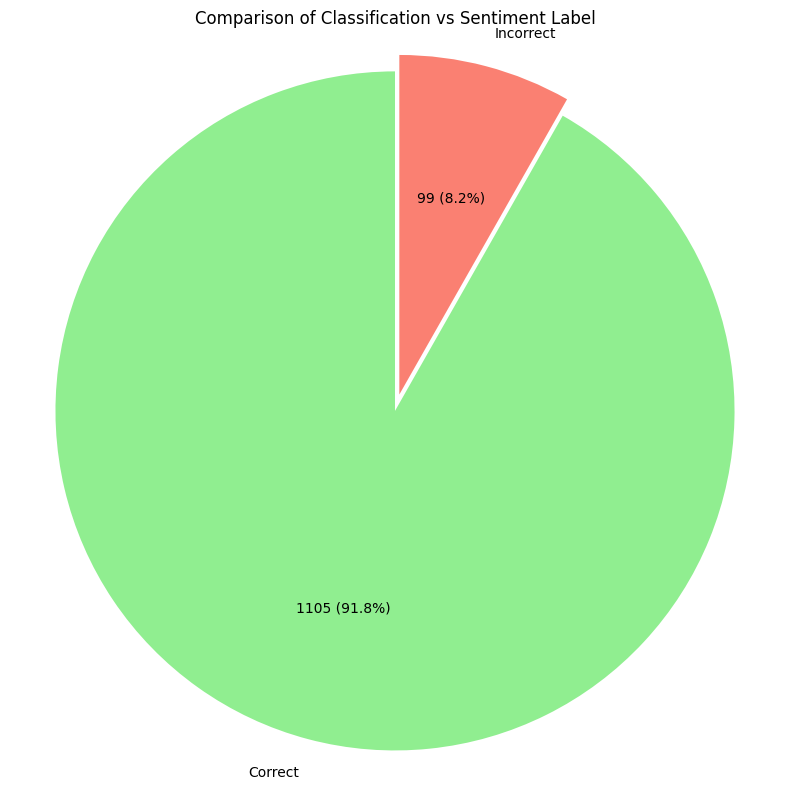

In [32]:
# Create a new column 'Match' to check if 'Classification' and 'Label' columns match
df['Match'] = df['Classification'] == df['Model_Classification']  # True if match, False otherwise

# Count occurrences of correct and incorrect matches
match_counts = df['Match'].value_counts()
match_labels = ['Correct', 'Incorrect']  # Pie chart labels

# Function to display both the count and percentage on the pie chart
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))  # Calculate count based on percentage
        return f'{count} ({pct:.1f}%)'  # Return count and percentage
    return my_format

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    match_counts,               # Data to plot
    labels=match_labels,        # Labels for the pie chart
    autopct=autopct_format(match_counts),  # Show count and percentage
    startangle=90,              # Start angle for the pie chart
    colors=['lightgreen', 'salmon'],  # Set colors for the sections
    explode=[0.05, 0]           # Slightly separate the 'Correct' section for emphasis
)

plt.title('Comparison of Classification vs Sentiment Label')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()

# Save the pie chart as an image file
plt.savefig(os.path.join(output_dir, 'classification_vs_label_pie_chart.png'))

# Show the pie chart
plt.show()